In [17]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
mongo_uri = ""
client = MongoClient(mongo_uri, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [19]:
db = client['test']
orders_collection = db['orders']
orders_documents = orders_collection.find()
orders_df = pd.DataFrame(orders_documents)
mod_orders_df = orders_df.drop(columns=['createdAt', 'deliveryStatus', '__v', '_id', 'items'])
mod_orders_df = mod_orders_df.groupby(orders_df['createdBy']).aggregate({'totalPrice': 'sum', 'createdBy': 'count'})
mod_orders_df = mod_orders_df.rename(columns={"totalPrice": "totalSpent", 'createdBy': 'totalOrders'});
mod_orders_df

,totalSpent,totalOrders
createdBy,,
64eeea7d00e301281e3de04b,267675.29,17
64eeea7d00e301281e3de04c,482816.06,25
64eeea7d00e301281e3de04d,361984.78,20
64eeea7d00e301281e3de04e,239445.66,16
64eeea7d00e301281e3de04f,347929.91,23
...,...,...
64eeea7d00e301281e3de42e,496013.77,44
64eeea7d00e301281e3de42f,612144.62,30
64eeea7d00e301281e3de430,670792.71,45


In [20]:
preprocessor = Pipeline([
    ("scaler", StandardScaler())
])

clusterer = Pipeline([
    ("kmeans", 
    KMeans(
        n_clusters=3,   
        init="k-means++",
        n_init=50,
        max_iter=500,
    ))
])

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clusterer", clusterer)
])

pipe.fit(mod_orders_df)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3,
                                         n_init=50))]))])

c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\personal-repos\y3s2\spm\ml\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

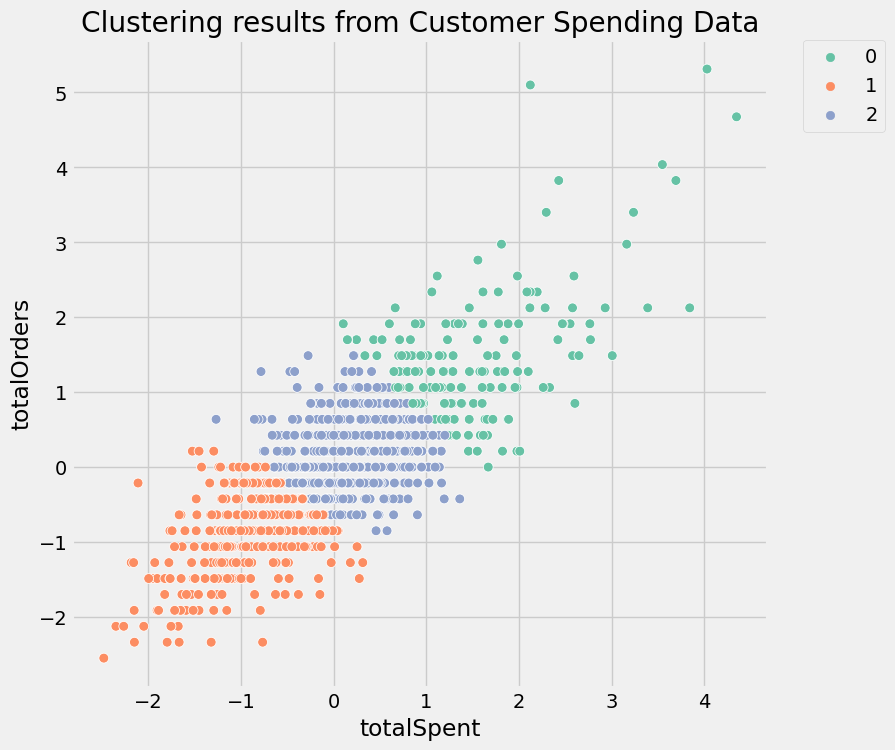

In [21]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(mod_orders_df),
    columns=["totalSpent", "totalOrders"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="totalSpent",
    y="totalOrders",
    s=50,
    data=pcadf,
    palette="Set2",
    hue="predicted_cluster"
)

scat.set_title(
    "Clustering results from Customer Spending Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()